# Tiled Primer Design

This jupyter notebook semi-automates the process of designing primers using k-mers for tiled PCR amplification across random sites in a single genome. 


### User Notes


I have re-written the script such that it no longer changes directories. Therefore, I recommend storing all files in one local (not Google Drive!) directory (i.e. jupyter notebook, genome.fasta, excel sheet). The generated fasta, xml, and db files will also be exported to this directory. 



### Credit

Written by Julie Chen (June/July 2020) for Python 3 \
Some adaptions from MATLAB script written by Gowtham Thakku
Additions by Gowtham Thakku

## Set up 

In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Blast import NCBIXML
from Bio.SeqUtils import MeltingTemp as mt
import numpy as np
import pandas as pd
import itertools
import re
import xlrd

In [2]:
# declare some modifiable parameters here:

date = '20210728'
kmerSize = 5
genomeFileName = '../NC_000962.fasta'
# genomeFileName = '../IS6110_IS1801.fasta'
record = SeqIO.read(genomeFileName, 'fasta')
fastaSeq = record.seq

# note: few more manual inputs later (see Doc for more instructions)

## Designing Primers

### Extract initial primer sequences using a chosen k-mer

**How to tell if a k-mer will likely self-dimerize**: Does the reverse (NOT rc) mostly bind to the forward sequence of the k-mer? If so, don't use this k-mer. \
e.g. F: 5' GCTGC 3' would be R: 3' CGTCG 5' which is complementary at 4/5 positions

In [3]:
# based on the "compatible" k-mers identified, select a set of k-mers to use

chosenKmers = ['AGCAG', 'TCCAC', 'GTTGC', 'GTTGA', 'CTCAA', 'CGATG']
#Set other parameters for run
gRNA_size = 28
wiggleRoom = 20
primerLength = 30

In [4]:
kmerPositionsF = []
kmerPositionsR = []
kmerSeqColumn = 'k-mer sequence'
genomeSeq = fastaSeq


# function to find all positions of a particular kmer in the genome
def listAllPositions(kmer, genomeSeq = fastaSeq):
    
    pattern = re.compile(r'(?=(' + kmer + '))')
    positions = [p.start() for p in re.finditer(pattern, str(genomeSeq))]
    
    return positions

# function to find the reverse complement of a given sequence
def revComplementSeq(seqtoRC):
    
    seqObject = Seq(seqtoRC)
    rc = seqObject.reverse_complement()
    
    return rc

def gcContentFrac(seqGC):
    gcNum = seqGC.count('G')+seqGC.count('g')+seqGC.count('C')+seqGC.count('c')
    gcFrac = gcNum/len(seqGC)
    
    return gcFrac

# loop to identify all compatible positions of kmers within acceptable distance

for currKmer in chosenKmers:

    
    positions_currKmer = listAllPositions(currKmer, genomeSeq)

    compatiblePositions = []
    compatiblePositionsR = []

    for currPos in positions_currKmer:

        primerSpace_start = currPos + kmerSize + gRNA_size 
        primerSpace_end = primerSpace_start + wiggleRoom + kmerSize

        if primerSpace_end < len(genomeSeq):
            searchSpace = str(genomeSeq[primerSpace_start:primerSpace_end])
        else:
            searchSpace = ''

        for searchKmer in chosenKmers:
            kmer_rc = revComplementSeq(searchKmer) 
            if searchSpace.find(str(kmer_rc)) > -1:
                compatiblePositions.append(currPos)
                compatiblePositionsR.append(searchSpace.find(str(kmer_rc))+primerSpace_start)
                break

    kmerPositionsF.extend(compatiblePositions)
    kmerPositionsR.extend(compatiblePositionsR)




# function to find 3'-end positions for compatible forward kmer positions
def find3EndF(kmerIndices):
    
    ends = [(i + kmerSize) for i in kmerIndices]
        
    return ends

positions3F = find3EndF(kmerPositionsF)

kmerSeqColumn = 'k-mer sequence'
genomeSeq = fastaSeq
        
    
print("Number of F primer Positions: ",len(kmerPositionsF))
print("Number of R primer Positions: ",len(kmerPositionsR))



#function to find distance between 3' ends of foward and reverse primers
def positionDifference(revList, forList):
    
    differences = [(revList[r] - forList[r]) for r in range(len(revList))]
    return differences

kmerPositionDiff = positionDifference(kmerPositionsR, positions3F)

#function to get forward primer sequences
def initialPrimerSeqF(positionsF, genomeSeq = fastaSeq, length = primerLength-kmerSize):
    
    primerSequences = []
    
    for i in positionsF:
        
        primerStart = i - length
        primerEnd = i + kmerSize
        primerSequences.append(str(genomeSeq[primerStart:primerEnd]))
    
    return primerSequences


#function to get forward primer sequences
def initialPrimerSeqR(positionsR, genomeSeq = fastaSeq, length = primerLength-kmerSize):
    
    primerSequences = []
    
    for i in positionsR:
        
        primerEnd = i + kmerSize + length
        rcSeq = revComplementSeq(str(genomeSeq[i:primerEnd]))
        primerSequences.append(str(rcSeq))
    
    return primerSequences

primerSeqF = initialPrimerSeqF(kmerPositionsF)
primerSeqR = initialPrimerSeqR(kmerPositionsR)

gcFractionR = []
gcFractionF = []
for currPrimer in primerSeqF:
    gcFractionF.append(gcContentFrac(currPrimer))
for currPrimer in primerSeqR:
    gcFractionR.append(gcContentFrac(currPrimer))
    
len(kmerPositionDiff)

TmPrimerF = []
TmPrimerR = []
for currPrimer in primerSeqF:
    TmPrimerF.append(mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4))
for currPrimer in primerSeqR:
    TmPrimerR.append(mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4))
    
primerInitialSeq = {'primerF sequence': primerSeqF, 'primerR sequence': primerSeqR,
                    'kmer index': kmerPositionsF,
                    'primerF 3': positions3F, 'primerR 3': kmerPositionsR, 
                    'position difference': kmerPositionDiff, 'gcFracF': gcFractionF, 'gcFracR': gcFractionR, 'TmPrimerF': TmPrimerF, 'TmPrimerR': TmPrimerR}

df_primerSeq = pd.DataFrame(primerInitialSeq)
df_primerSeq.head()





df_primerSeq_filtered = df_primerSeq



#Adapter to add to the forward primers
adaptPrimerF = 'gaaatTAATACGACTCACTATAGGG'
# adaptGuide = 'GTTTTAGTCCCCTTCGTTTTTGGGGTAGTCTAAATCCCCTATAGTGAGTCGTATTAatttc'
# adaptPrimerR = 'CAGGAAACAGCTATGAC'
adaptPrimerR = ''
df_primerSeq_filtered['primerF sequence'] = adaptPrimerF + df_primerSeq_filtered["primerF sequence"].astype(str)
df_primerSeq_filtered['primerR sequence'] = adaptPrimerR + df_primerSeq_filtered["primerR sequence"].astype(str)


#Screening primers to see if kmer binding sites exist
for currKmer in chosenKmers:
    print("Filtering sequence:", kmer_rc)
    kmer_rc = str(revComplementSeq(currKmer))
    df_primerSeq_filtered["Fexclude"]=df_primerSeq_filtered["primerF sequence"].str.find(kmer_rc)
    df_primerSeq_filtered["Rexclude"]=df_primerSeq_filtered["primerR sequence"].str.find(kmer_rc)
    df_primerSeq_filtered = df_primerSeq_filtered[df_primerSeq_filtered.Fexclude < 0]
    df_primerSeq_filtered = df_primerSeq_filtered[df_primerSeq_filtered.Rexclude < 0]
    print("Remaining primer pairs:", df_primerSeq_filtered.shape)
    

Number of F primer Positions:  5945
Number of R primer Positions:  5945
Filtering sequence: GCAAC
Remaining primer pairs: (5532, 12)
Filtering sequence: CTGCT
Remaining primer pairs: (5287, 12)
Filtering sequence: GTGGA
Remaining primer pairs: (4832, 12)
Filtering sequence: GCAAC
Remaining primer pairs: (4597, 12)
Filtering sequence: TCAAC
Remaining primer pairs: (4433, 12)
Filtering sequence: TTGAG
Remaining primer pairs: (3878, 12)


In [5]:
#Set path to file that contains filtered 28-mers that are unique to the pathogen of interest

uniqueGenomeFileName = '../staph_unique_targets.fasta'

uniqueSeq = []
uniquePos = []

#Reading 28-mer positions that are unique (based on header) and storing positions in a list (uniquePos)
for record in SeqIO.parse(uniqueGenomeFileName, "fasta"):
    uniqueSeq.append(str(record.seq))
    curr_id = record.id
    pos = curr_id.find("_")
    uniquePos.append(int(curr_id[pos+1:]))

#Using the unique positions to create a genome map of unique regions (1 instead of 0)
fastaSeqUnique = np.zeros(len(fastaSeq,), dtype=int)
for i in uniquePos:
    fastaSeqUnique[i-1]=1

# fastaSeqUnique = np.ones(len(fastaSeq,), dtype=int)

In [6]:
#Additional filtering for ensuring
# primers and guide fall in a unique part of the genome
# amplicons don't overlap with one another
# amplicons don't contain homopolymeric regions
# primers are not repeated

df_primerSeq_filtered2 = df_primerSeq_filtered

fastaSeqOccupied = np.zeros(len(fastaSeq), dtype=int)

for index, row in df_primerSeq_filtered.iterrows():
    currF = row['primerF 3']
    currR = row['primerR 3']

    df_primerSeq_filtered2.loc[index,'ampUnique'] = sum(fastaSeqUnique[currF:currR-28])
    df_primerSeq_filtered2.loc[index,'fUnique10'] = sum(fastaSeqUnique[currF-28-5:currF-28])
    df_primerSeq_filtered2.loc[index,'rUnique10'] = sum(fastaSeqUnique[currR:currR+5])
    df_primerSeq_filtered2.loc[index,'amplicon'] = fastaSeq[currF:currR]
    if sum(fastaSeqOccupied[currF-20:currR+20]>0):
        df_primerSeq_filtered2.loc[index,'occupied'] = 2
    else:
        df_primerSeq_filtered2.loc[index,'occupied'] = 1
        fastaSeqOccupied[currF-20:currR+20] = np.ones(len(range(currF-20,currR+20)))
        
    primerF = row['primerF sequence']
    primerR = row['primerR sequence']
    
    
df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2.gcFracF<0.9]
df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2.gcFracR<0.9]      
df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2.ampUnique>0]
df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2.fUnique10>4]
df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2.rUnique10>4]
df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2.occupied<2]

excludeSeq = ['AAAAA', 'TTTTT','CCCCC', 'GGGGG', 'NNNNN']

for currExclude in excludeSeq:
    df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2["primerF sequence"].str.find(currExclude)<0]
    df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2["primerR sequence"].str.find(currExclude)<0]
    df_primerSeq_filtered2 = df_primerSeq_filtered2[df_primerSeq_filtered2["amplicon"].str.find(currExclude)<0]
# for index, row in df_primerSeq_filtered.iterrows():
#     currF = row['primerF 3']
#     currR = row['primerR 3']
#     print(">",index)
#     print(fastaSeq[currF:currR])

excludeSeq2 = ['AACCCACTACGCAGCCAATCTGATGGCAGC',\
'AATTGCGAAGGGCGAACGCGATTTTAAAGA',\
'AGGGGTGTGGTGTACGGGCAGGTAAGGCCG',\
'ATCAGTTGTTGCCCAATATGATCGGGTACT',\
'ATCCTGGGCTGGCGGGTCGCTTCCACGATG',\
'ATCTCTGCGACCATCCGCACCGCCCGCTCA',\
'CAAGTCGCAAGTGTCGATCATGGCCAAAGA',\
'CAGCCGCGTCCACGCCGCCAACTACGGTGT',\
'CCAACAAGAAGGCGTACTCGACCTGAAAGA',\
'CCAACCGTCGGTCGGAGCGGTCGGAAGCTC',\
'CCCGGTTGATGTGGTCGTAGTAGGTCGATG',\
'CCGCCAGGGCTTGCCGGGTTTGATCAGCTC',\
'CCGCGGTCAGCACGATTCGGAGTGGGCAGC',\
'CCGGATCAGCGATCGTGGTCCTGCGGGCTT',\
'CCTCGAGGTCCTCACCCGAGCCCGAGCAGC',\
'CCTTCCTCGCCGCCGACGCCCTGGTGCTCA',\
'CGAGGGCCCCGATGGTTTGCGGTGGGGTGT',\
'CGATGAACCGGGTAATTAGCGTGCTGGCCG',\
'CGCCTTCTTGTTGGCGGGTCCAGATGGCTT',\
'CGGCGAGCCGCTCGCTGAACCGGATCGATG',\
'CGGCGTTGACGCCGGTGGCGATCAAGGTGT',\
'CGTTCGACGGTGCATCTGGCCACCTCGATG',\
'CTGGTGACCAGCGCGACCCCGGACAGGCCG',\
'CTTGGAAAGGATGGGGTCATGTCAGGTGGT',\
'GCACCCACTTACGCACCGTCTCCGCGCAGC',\
'GCGGGGCGGGCTACCGCGAACGCAGCGATG',\
'GCGTCGGCGGCGAGGAAGGTATACGGGCCG',\
'GGCGTTGTCCCGCCGCAAGCGCTTCAGCTC',\
'TCCAGGTCACCTCCGCCGAGGACGGGGCCG',\
'TCGCGACGTCGATGGTTGCGGCACGGGTGT',\
'TTGCTGGTCGTTTCGAAGGATCACGCGATG',\
'CAGATGCACCGTCGAACGGCTGATGACCAA']

for currSeq in excludeSeq2:   
    # Get names of indexes for which column Age has value 30
    indexNames = df_primerSeq_filtered2[ df_primerSeq_filtered2['primerR sequence'] == currSeq ].index
    # Delete these row indexes from dataFrame
    df_primerSeq_filtered2.drop(indexNames, inplace=True)
    




duplicate = df_primerSeq_filtered2[df_primerSeq_filtered2.duplicated(['primerF sequence','primerR sequence'])]

duplicate.shape

(1, 17)

In [7]:
curr_df = df_primerSeq_filtered2

#Set the melting temperature
medianTm = curr_df['TmPrimerF'].median()
medianTm = 68

primerF = curr_df['primerF sequence']
primerR = curr_df['primerR sequence']

newPrimerF = []
newTmF = []
for currPrimer in primerF:
    currPrimer = currPrimer[25:]
    currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    while currTm > medianTm + 1 and len(currPrimer)>17:
        currPrimer = currPrimer[1:]
        currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    newPrimerF.append(currPrimer)
    newTmF.append(currTm)
        
newPrimerR = []
newTmR = []
for currPrimer in primerR:
    currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    while currTm > medianTm + 1 and len(currPrimer)>17:
        currPrimer = currPrimer[1:]
        currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    newPrimerR.append(currPrimer) 
    newTmR.append(currTm)
    
curr_df['primerF sequence'] = newPrimerF
curr_df['primerR sequence'] = newPrimerR
        
curr_df['primerF sequence'] = adaptPrimerF + curr_df["primerF sequence"].astype(str)
curr_df['primerR sequence'] = adaptPrimerR + curr_df["primerR sequence"].astype(str)

curr_df['TmPrimerF'] = newTmF
curr_df['TmPrimerR'] = newTmR


#Screening primers to see if kmer binding sites exist
for currKmer in chosenKmers:
    print("Filtering sequence:", kmer_rc)
    kmer_rc = str(revComplementSeq(currKmer))
    curr_df["Fexclude"]=curr_df["primerF sequence"].str.find(kmer_rc)
    curr_df["Rexclude"]=curr_df["primerR sequence"].str.find(kmer_rc)
    curr_df = curr_df[curr_df.Fexclude < 0]
    curr_df = curr_df[curr_df.Rexclude < 0]
    print("Remaining primer pairs:", curr_df.shape)
    
excludeSeq = ['AAAAA', 'TTTTT','CCCCC', 'GGGGG', 'NNNNN']

for currExclude in excludeSeq:
    curr_df = curr_df[curr_df["primerF sequence"].str.find(currExclude)<0]

Filtering sequence: CATCG
Remaining primer pairs: (319, 17)
Filtering sequence: CTGCT
Remaining primer pairs: (319, 17)
Filtering sequence: GTGGA
Remaining primer pairs: (319, 17)
Filtering sequence: GCAAC
Remaining primer pairs: (319, 17)
Filtering sequence: TCAAC
Remaining primer pairs: (319, 17)
Filtering sequence: TTGAG
Remaining primer pairs: (319, 17)


(array([   2.,    4.,    6.,   19.,   90., 1092., 1399.,   11.,    3.,
           3.]),
 array([60.10841769, 61.45685934, 62.80530099, 64.15374264, 65.50218429,
        66.85062594, 68.19906759, 69.54750924, 70.89595089, 72.24439253,
        73.59283418]),
 <a list of 10 Patch objects>)

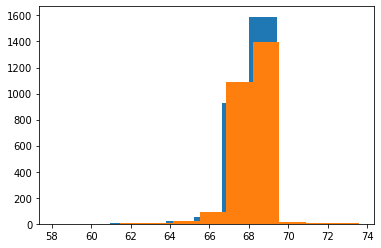

In [20]:
import matplotlib.pyplot as plt

plt.hist(curr_df['TmPrimerF'])
plt.hist(curr_df['TmPrimerR'])

In [21]:
curr_df['repeat'] = np.where(curr_df.duplicated(['primerF sequence','primerR sequence']), True, False)

In [22]:
df_primerSeq_filtered2 = curr_df

### Append adapters to F primer and guide target

In [23]:
# adaptPrimerF = 'gaaatTAATACGACTCACTATAGGG'
adaptGuide = 'GTTTTAGTCCCCTTCGTTTTTGGGGTAGTCTAAATCCCCTATAGTGAGTCGTATTAatttc'

# df_primerSeq_filtered['FprimerToOrder'] = adaptPrimerF + df_primerSeq_filtered["primerF sequence"].astype(str)
df_primerSeq_filtered2['GuideToOrder'] = df_primerSeq_filtered2["amplicon"].astype(str) + adaptGuide

In [24]:
savename = date
# for currKmer in chosenKmers:
#     savename = savename+'_'+currKmer

savename = savename+'_'+str(len(df_primerSeq_filtered2))+'primers_'+str(len(chosenKmers))+'kmers.csv'
df_primerSeq_filtered2.to_csv(savename)

In [11]:
curr_df = pd.read_csv('18primers_11kmers.csv')

#Set the melting temperature
medianTm = 68

primerF = curr_df['primerF sequence']
primerR = curr_df['primerR sequence']

newPrimerF = []
newTmF = []
for currPrimer in primerF:
    currPrimer = currPrimer[25:]
    currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    while currTm > medianTm + 1 and len(currPrimer)>17:
        currPrimer = currPrimer[1:]
        currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    newPrimerF.append(currPrimer)
    newTmF.append(currTm)
        
newPrimerR = []
newTmR = []
for currPrimer in primerR:
    currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    while currTm > medianTm + 1 and len(currPrimer)>17:
        currPrimer = currPrimer[1:]
        currTm = mt.Tm_NN(currPrimer, Na=50, Tris=10, Mg=0.4)
    newPrimerR.append(currPrimer) 
    newTmR.append(currTm)
    
curr_df['primerF sequence'] = newPrimerF
curr_df['primerR sequence'] = newPrimerR
        
curr_df['primerF sequence'] = adaptPrimerF + curr_df["primerF sequence"].astype(str)
curr_df['primerR sequence'] = adaptPrimerR + curr_df["primerR sequence"].astype(str)

curr_df['TmPrimerF'] = newTmF
curr_df['TmPrimerR'] = newTmR


#Screening primers to see if kmer binding sites exist
for currKmer in chosenKmers:
    print("Filtering sequence:", kmer_rc)
    kmer_rc = str(revComplementSeq(currKmer))
    curr_df["Fexclude"]=curr_df["primerF sequence"].str.find(kmer_rc)
    curr_df["Rexclude"]=curr_df["primerR sequence"].str.find(kmer_rc)
    curr_df = curr_df[curr_df.Fexclude < 0]
    curr_df = curr_df[curr_df.Rexclude < 0]
    print("Remaining primer pairs:", curr_df.shape)

Filtering sequence: ACCAC
Remaining primer pairs: (18, 17)
Filtering sequence: TCTTT
Remaining primer pairs: (18, 17)
Filtering sequence: TTGGT
Remaining primer pairs: (18, 17)
Filtering sequence: GAGCT
Remaining primer pairs: (18, 17)
Filtering sequence: CATCG
Remaining primer pairs: (18, 17)
Filtering sequence: GCTGC
Remaining primer pairs: (18, 17)
Filtering sequence: TGAGC
Remaining primer pairs: (18, 17)
Filtering sequence: CGGCC
Remaining primer pairs: (18, 17)
Filtering sequence: AAGCC
Remaining primer pairs: (18, 17)
Filtering sequence: ACACC
Remaining primer pairs: (18, 17)
Filtering sequence: AGTAC
Remaining primer pairs: (18, 17)


In [3]:
df_primerSeq_filtered = pd.read_csv('20210728_2629primers_11kmers.csv')

In [4]:
df_1_384 = df_primerSeq_filtered.head(384)

df_1_384 = df_1_384.assign(chrom = 'NC_000962.3')
df_1_384 = df_1_384.assign(locus = 'Locus_'+ df_1_384.iloc[:,0].astype(str))

In [12]:
df_bed_index = df_1_384[['chrom', 'primerF 3', 'primerR 3', 'locus']]
df_bed_index.loc[:, "primerF 3"] = df_bed_index["primerF 3"].subtract(10)
df_bed_index.loc[:, "primerR 3"] = df_bed_index["primerR 3"].add(10)

df_bed_index.head()
df_bed_index.to_csv('H37Rv_PCR_384x.bed', index=False, header=False, sep='\t')

/Users/gowtham/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [3]:
len(fastaSeq)

4411532